# Data Analysis

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import sklearn.linear_model as lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

In [2]:
# Write query function

def execute_query(sql):
    conn = psycopg2.connect("dbname=dbproject_new user=postgres password=141218")
    conn.autocommit = True
    cursor = conn.cursor()

    cursor.execute(sql)

    # Get all tuples and column names
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]

    # Close connection
    cursor.close()
    conn.close()

    # Create df
    df = pd.DataFrame(rows, columns=column_names)
    return df

In [112]:
def set_plot_style(title, fontweight='bold', fontsize=16, labelsize=12):
    plt.title(title, fontweight=fontweight, fontsize=fontsize)
    plt.xlabel('')
    plt.ylabel('')
    plt.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.show()

In [206]:
def save_plot(plot, plot_name, path='/Users/dthuerkauf/Desktop/Programming/lecture-databases/group-17/data-analysis/figures',file_type='pdf'):
    plot.savefig(f"{path}/{plot_name}.{file_type}",format=file_type)

In [213]:
def dataframe_to_latex(df, columns=None):
    if columns is not None:
        df = df[columns]
    return df.to_latex(index=False)

### Test query to see if notebook connects to db

This query should return the Akanji card which sold for the highest price.

In [3]:
sql = '''
SELECT * 
FROM card c
JOIN nft n ON c.assetid = n.assetid
JOIN ownershiphistory oh ON n.nftid = oh.nftid
WHERE c.lastname = 'Akanji'
AND oh.priceeuro >= ALL (SELECT oh2.priceeuro 
                        FROM card c2
                        JOIN nft n2 ON c2.assetid = n2.assetid
                        JOIN ownershiphistory oh2 ON n2.nftid = oh2.nftid
                        WHERE c2.lastname = 'Akanji');

'''
df = execute_query(sql)
display(df)

,assetid,rarity,seasonyear,birthdate,bestfoot,firstname,lastname,shirtnumber,nftid,assetid,slug,currentowneraddress,address,transferdate,priceeuro,transfertype,blockchain,nftid
0,0x04003791deb1ffd84c9ca892c01befac0687ef59fc08...,super_rare,2021,1995-07-19,right,Manuel Obafemi,Akanji,25,Starkware::MintableERC721Token:0e805b04-901e-4...,0x04003791deb1ffd84c9ca892c01befac0687ef59fc08...,manuel-obafemi-akanji-2021-super_rare-1,0x02729dd51a8a75292c01b1c5932ab5fdbd70af766260...,0x02729dd51a8a75292c01b1c5932ab5fdbd70af766260...,2022-01-07 21:01:44,3305.288784,ENGLISH_AUCTION,STARKWARE,Starkware::MintableERC721Token:0e805b04-901e-4...


### Card rarities

,rarity,count,percentage,count_in_k
0,limited,748520,78.039036,748.520
1,rare,181988,18.973666,181.988
2,super_rare,26290,2.740937,26.290
3,unique,2363,0.246361,2.363


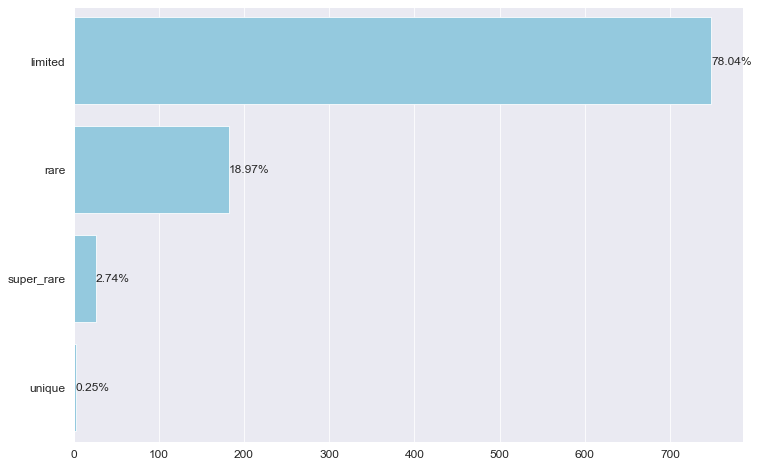

In [308]:
sql = '''
SELECT rarity, COUNT(rarity)
FROM card c
GROUP BY c.rarity
ORDER BY COUNT(rarity) DESC
'''
rarities = execute_query(sql)
rarities['percentage'] = ((rarities['count'] / rarities['count'].sum()) * 100)
rarities['count_in_k'] = rarities['count'] / 1000
display(rarities)

plt.figure(figsize=(12, 8))

sns.set_theme(context='paper')
sns.barplot(
    data = rarities,
    x='count_in_k', y= 'rarity',
    color = "skyblue")

ax = plt.gca()

for index, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width(), p.get_y() + p.get_height()/2, f'{rarities["percentage"][index]:.2f}%', 
        fontsize=12, ha='left', va='center') 

set_plot_style('')

fig = ax.get_figure()
fig.savefig('g17-cards_by_rarity.pdf', format='pdf')

### Ten highest card sales

,rarity,seasonyear,firstname,lastname,priceeuro,transferdate,callname
0,unique,2021,Kylian,Mbappé Lottin,415.91988,2022-05-04 18:30:45,Kylian Mbappé
1,unique,2021,Vinícius José,Paixão de Oliveira Júnior,334.91329,2022-02-13 22:01:52,Vinícius Jr.
2,unique,2020,Cristiano Ronaldo,dos Santos Aveiro,238.28550,2021-03-13 23:56:19,Cristiano Ronaldo
3,unique,2021,Lionel Andrés,Messi Cuccittini,234.88717,2022-03-27 21:01:48,Lionel Messi
4,unique,2021,Florian Richard,Wirtz,214.21512,2022-03-11 19:03:49,Florian Wirtz
5,super_rare,2019,Arnaud,Bodart,208.73391,2020-05-10 21:28:15,Arnaud Bodart
6,unique,2021,Gianluigi,Donnarumma,155.18701,2021-12-05 22:02:50,Gianluigi Donnaruma
7,unique,2021,Marcos,Aoás Corrêa,143.40357,2022-02-15 21:02:49,Marquinhos
8,unique,2020,Paul Labile,Pogba,117.92681,2022-02-07 13:40:47,Paul Pogba
9,rare,2018,Victor James,Osimhen,106.24913,2020-04-29 07:49:47,Victor Osimhen


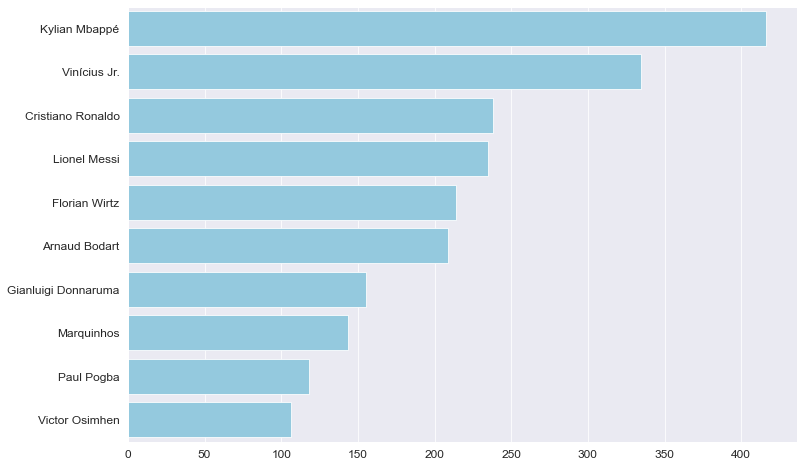

In [307]:
sql = '''
SELECT rarity, seasonyear, firstname, lastname, priceeuro, transferdate
FROM card c
JOIN nft n ON c.assetid = n.assetid
JOIN ownershiphistory oh ON n.nftid = oh.nftid
ORDER BY oh.priceeuro DESC
LIMIT 10
'''

# Create pandas df
most_expensive_cards = execute_query(sql)
most_expensive_cards['priceeuro'] = most_expensive_cards['priceeuro'].round(2)
#most_expensive_cards = most_expensive_cards.drop(columns=['transferdate'])
most_expensive_cards['callname'] = ['Kylian Mbappé', 'Vinícius Jr.', 'Cristiano Ronaldo', 'Lionel Messi', 'Florian Wirtz', 'Arnaud Bodart', 'Gianluigi Donnaruma','Marquinhos','Paul Pogba', 'Victor Osimhen']
most_expensive_cards['priceeuro'] = most_expensive_cards['priceeuro']/1000
display(most_expensive_cards)

#x = dataframe_to_latex(most_expensive_cards)
#print(x)

# Visualize
plt.figure(figsize=(12, 8))

sns.set_theme(context='paper')
sns.barplot(
    data = most_expensive_cards,
    x='priceeuro', y= 'callname',
    color = "skyblue")

ax = plt.gca()

set_plot_style('')

fig = ax.get_figure()
fig.savefig('g17-top10.pdf', format='pdf')

### Total trading volume

In [191]:
sql = '''
SELECT SUM(oh.priceeuro) AS total_volume
FROM ownershiphistory oh
'''

# Create df
df = execute_query(sql)
total_volume = int(df['total_volume'])//1000000
print('Total volume in Million Euros:',total_volume)


Total volume in Million Euros: 173


## Distribution of card sale prices

To get a sense of the data, we want to show a histogram of all card sale prices. The distribution of normal prices is heavily skewed due to large outliers. To account for this, we took the natural logarithm of the price, as well as the logarithm of a players' average card price.


94.00462637509301 745.1354986839797


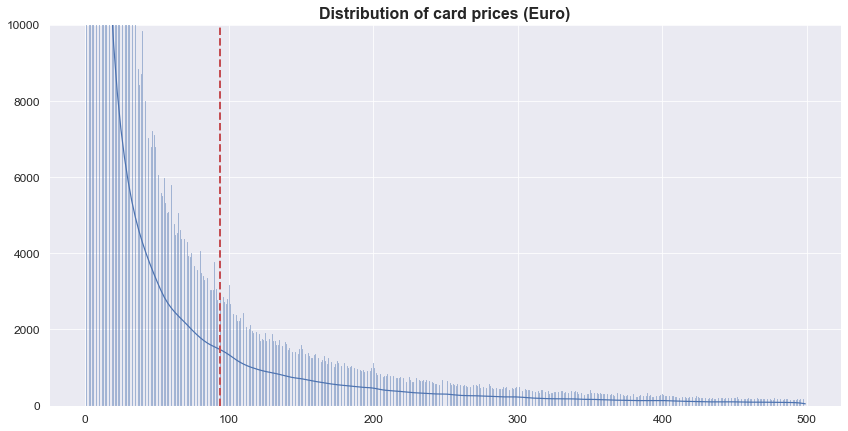

In [117]:
# Normal Price
sql = '''
SELECT oh.priceeuro
FROM ownershiphistory oh
ORDER BY oh.priceeuro DESC
'''

# Create pandas df
all_prices = execute_query(sql)
all_prices['priceeuro'] = all_prices['priceeuro'].apply(round)
#display(all_prices)

# Mean and Std
mean = all_prices['priceeuro'].mean(axis=0)
std = all_prices['priceeuro'].std()
print(mean, std)

# Clean data to see something on histogram
small = all_prices[all_prices['priceeuro']<500]

# Visualize
sns.set_theme(context='paper')
plot = sns.displot(data=small, x='priceeuro', kind = 'hist', kde=True, bins=1000, height=6, aspect=2 )
plot.set(ylim=(0, 10000))
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)

set_plot_style("Distribution of card prices (Euro)")

1.2313996809253942 0.7839205518461762


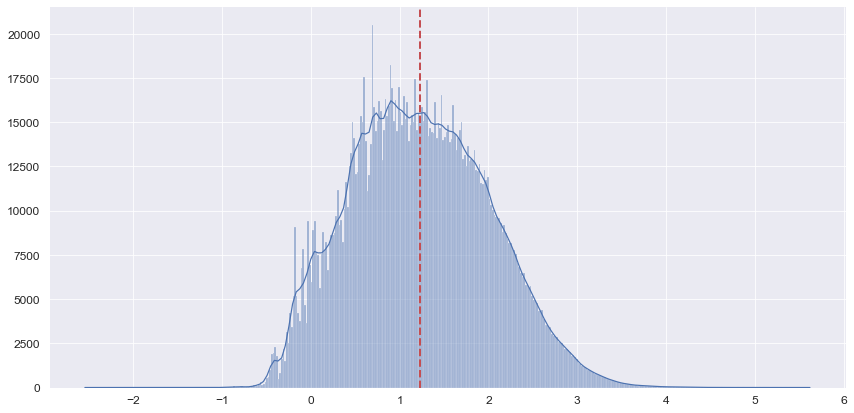

In [427]:
# Log(price)
sql = '''
SELECT LOG(oh.priceeuro)
FROM ownershiphistory oh
ORDER BY LOG(oh.priceeuro) DESC
'''

# Create pandas df
log_prices = execute_query(sql)
#display(log_prices)

# Mean and Std
mean = log_prices['log'].mean(axis=0)
std = log_prices['log'].std()
print(mean, std)

# Visualization
sns.set_theme(context='paper')
plot = sns.displot(data=log_prices, x='log', kind = 'hist', kde=True, height=6, aspect=2 )
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)

set_plot_style('')
save_plot(plot,'g17-distribution_log_prices')

1.4000457123475156 0.591369169288522


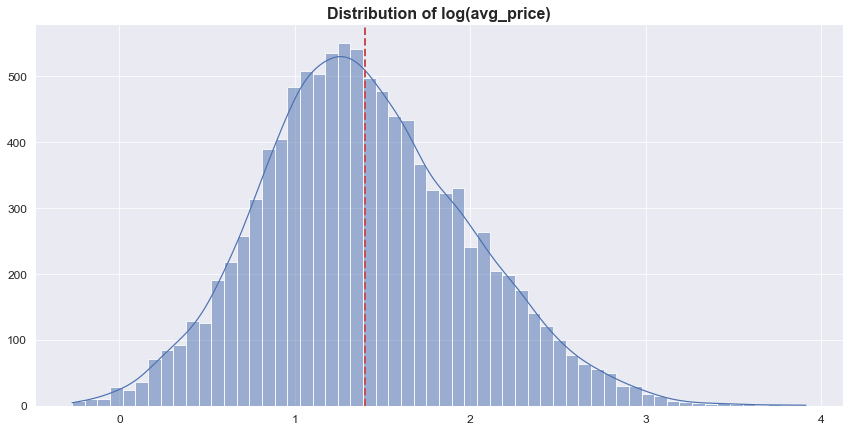

5.160532351513668


-2128.9094101905966

In [423]:
#Log(avg_price)
sql = '''
SELECT LOG(AVG(oh.priceeuro)) AS log_avg_price
FROM player p
JOIN card c ON c.firstname = p.firstname AND c.lastname = p.lastname AND c.birthdate = p.birthdate
JOIN nft n ON c.assetid = n.assetid
JOIN ownershiphistory oh ON n.nftid = oh.nftid
GROUP BY p.firstname, p.lastname, p.birthdate
'''

# Create pandas df
log_avg_prices = execute_query(sql)
#display(avg_prices)

# Descriptive statistic
mean = log_avg_prices['log_avg_price'].mean(axis=0)
std = log_avg_prices['log_avg_price'].std()
print(mean, std)

sns.set_theme(context='paper')
plot = sns.displot(data=log_avg_prices, x='log_avg_price', kind = 'hist', kde=True, height=6, aspect=2 )
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)

set_plot_style("Distribution of log(avg_price)")

70.4673945541751 197.38388676777146


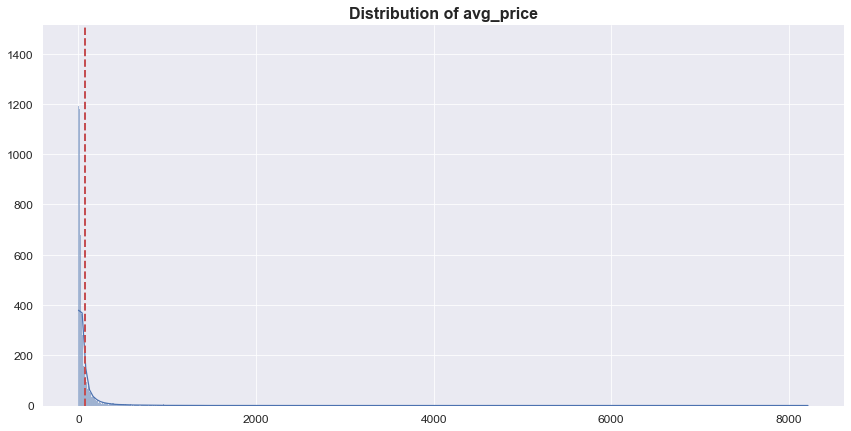

5.160532351513668


110.769177734623

In [426]:
#avg_price
sql = '''
SELECT AVG(oh.priceeuro) AS avg_price
FROM player p
JOIN card c ON c.firstname = p.firstname AND c.lastname = p.lastname AND c.birthdate = p.birthdate
JOIN nft n ON c.assetid = n.assetid
JOIN ownershiphistory oh ON n.nftid = oh.nftid
GROUP BY p.firstname, p.lastname, p.birthdate
'''

# Create pandas df
avg_prices = execute_query(sql)
#display(avg_prices)

# Descriptive statistic
mean = avg_prices['avg_price'].mean(axis=0)
std = avg_prices['avg_price'].std()
print(mean, std)

sns.set_theme(context='paper')
plot = sns.displot(data=avg_prices, x='avg_price', kind = 'hist', kde=True, height=6, aspect=2 )
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)

set_plot_style("Distribution of avg_price")

# Average price for goalkeepers
import math
gk_mean = math.log(174.257197)
print(gk_mean)
(112084)**0.5 * ((mean-gk_mean)/std)

## Daily Trading Volume
The next plot shows the daily trading volume over time

,priceeuro,transferdate,transfertime
0,11.010600,2019-03-08,15:01:07
1,10.722600,2019-03-13,20:58:04
2,6.420700,2019-03-14,19:19:57
3,3.033420,2019-03-14,20:34:12
4,108.568200,2019-03-14,21:16:54
...,...,...,...
1850644,0.728658,2022-12-01,23:28:45
1850645,119.014140,2022-12-01,23:30:28
1850646,12.022857,2022-12-01,23:38:45
1850647,4.007619,2022-12-01,23:42:40


                  priceeuro
transferdate               
2022-02-13    911300.948667


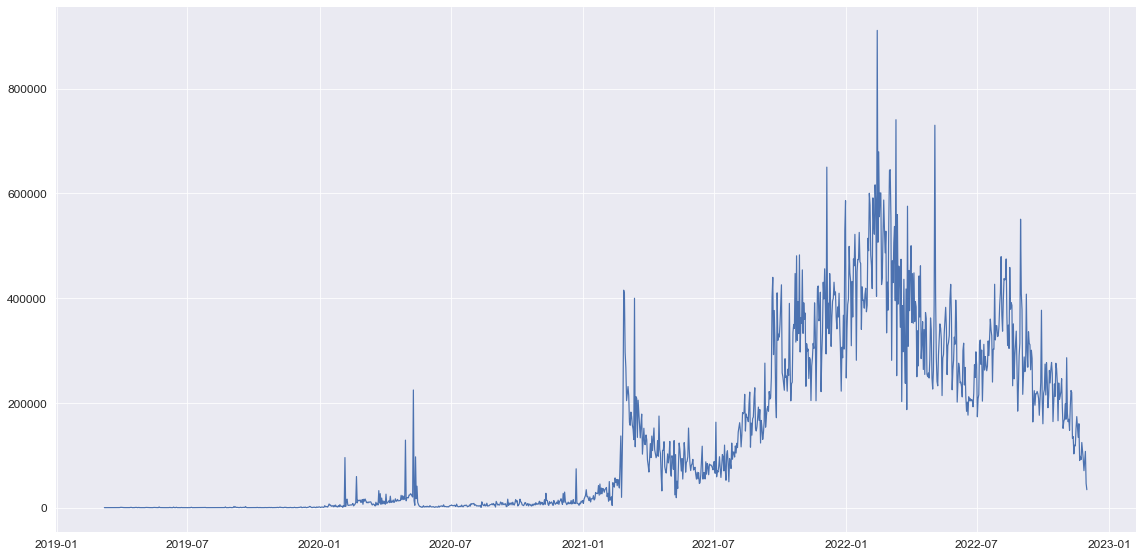

In [306]:
sql = '''
SELECT oh.priceeuro, oh.transferdate
FROM ownershiphistory oh
ORDER BY oh.transferdate ASC
'''

# Create df
price_date = execute_query(sql)
price_date[['transferdate', 'transfertime']] = price_date['transferdate'].astype('str').str.split(' ', expand=True)
price_date['transferdate'] = pd.to_datetime(price_date['transferdate'])
price_date.drop(price_date[price_date['transferdate'] == '2022-12-02'].index, inplace=True)
display(price_date)

volume_by_day = price_date.groupby("transferdate").sum()
print(volume_by_day[volume_by_day['priceeuro'] > 800000])
#display(volume_by_day)

sns.set_theme(context='paper')
plot = sns.relplot(
    data = volume_by_day, kind='line',
    x='transferdate', y= 'priceeuro', height=8, aspect=2)

set_plot_style('')

save_plot(plot,'g17-daily_trading_volume')

### Scatterplot: Player height and weight 
To see if there are outliers in the height and weight column of our players relation.

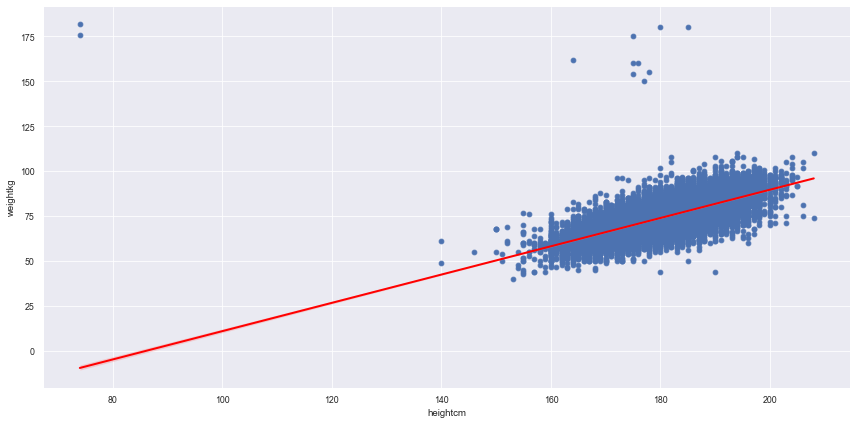

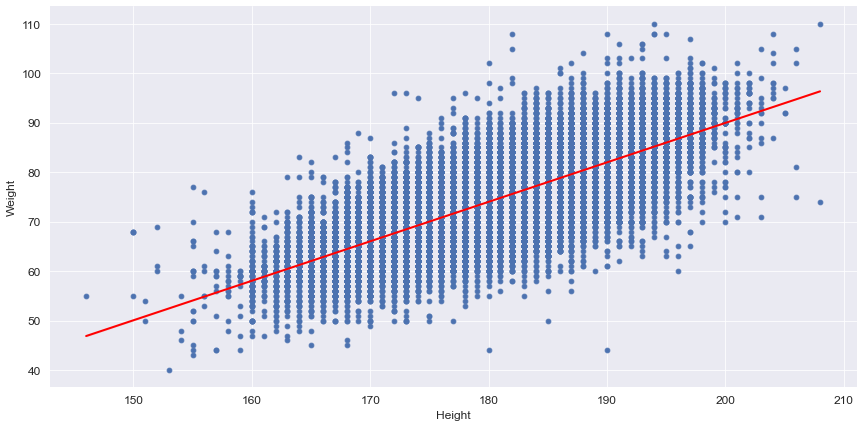

In [318]:
sql = '''
SELECT p.heightcm, p.weightkg
FROM player p
GROUP BY p.firstname, p.lastname, p.birthdate
ORDER BY p.heightcm DESC
'''

# Create df
df = execute_query(sql)


# Drop rows where we do not have the height or weigth of the player
df.drop(df[df['heightcm'] == 0].index, inplace=True)
df.drop(df[df['weightkg'] == 0].index, inplace=True)
#display(df)


# Visualize
sns.set_theme(context='paper')
sns.relplot(
    data = df, kind='scatter',
    x='heightcm', y= 'weightkg', height=6, aspect=2)
sns.regplot(x='heightcm', y='weightkg', data=df, line_kws={'color': 'red', 'lw': 2})

plt.show()

df = df.drop(df[df['heightcm'] < 141].index)
cleaned_df = df.drop(df[df['weightkg'] > 140].index)

# Visualize cleaned
sns.set_theme(context='paper')
plot = sns.relplot(
        data = cleaned_df, kind='scatter',
        x='heightcm', y= 'weightkg', height=6, aspect=2, sizes=[1])
sns.regplot(x='heightcm', y='weightkg', data=cleaned_df, line_kws={'color': 'red', 'lw': 2})

plt.title("", fontweight='bold', fontsize=16)
plt.xlabel('Height', fontsize=12)
plt.ylabel('Weight', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

save_plot(plot,'g17-corr_height_weight')

### Some birthdate outliers

In [317]:
sql = '''
SELECT p.firstname, p.lastname, p.birthdate, COUNT(*)
FROM player p
WHERE p.birthdate = '2022-11-25'
GROUP BY p.firstname, p.lastname, p.birthdate
ORDER BY p.birthdate DESC
'''

# Create df
df = execute_query(sql)
display(df)

,firstname,lastname,birthdate,count
0,Antti,Autio,2022-11-25,1
1,Jack,Higgins,2022-11-25,1
2,Jason,Riikonen,2022-11-25,1
3,Marc,Thompson,2022-11-25,1
4,Michael,Murray,2022-11-25,1
5,Olavi,Koli,2022-11-25,1
6,Robin,Julin,2022-11-25,1
7,Tyrone,Gay,2022-11-25,1
8,Ville,Pönkä,2022-11-25,1


### Histogram of player age

,playerid,firstname,lastname,birthdate,heightcm,weightkg,nationality
53,392321,Vahe,Sahakyan,2006-12-26,0,0,Armenia
54,378794,Joar,Brouneus,2006-12-24,0,0,Sweden
55,363384,Georgios,Michael,2006-12-21,0,0,Cyprus
56,323591,Sverre,Halseth Nypan,2006-12-19,0,0,Norway
57,373926,Henrijs,Auseklis,2006-12-19,0,0,Latvia
...,...,...,...,...,...,...,...
220920,367861,Abdullah,Al Bloushi,1960-02-16,0,0,Kuwait
220921,234102,Dave,Beasant,1959-03-20,186,0,England
220922,194500,Jorge Orlando,Aravena Plaza,1958-04-22,177,0,Chile
220923,337780,Djeljilj,Asani,1955-09-12,0,0,North Macedonia


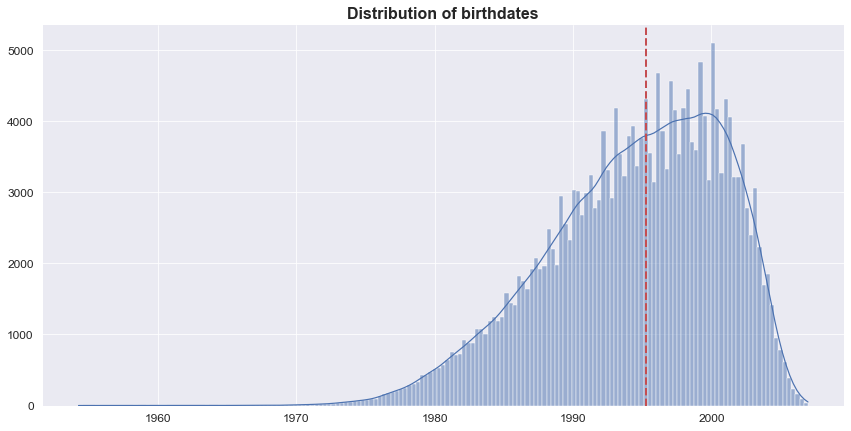

In [249]:
sql = '''
SELECT *
FROM player p
GROUP BY p.firstname, p.lastname, p.birthdate
ORDER BY p.birthdate DESC
'''

# Create df
df = execute_query(sql)

# Convert the 'birthdate' column to a datetime data type
df['birthdate'] = pd.to_datetime(df['birthdate'])

# Filter the DataFrame to include only rows with players over 16
df = df[df['birthdate'] < '2007-01-01']
median = df['birthdate'].median()
display(df)

sns.set_theme(context='paper')
plot = sns.displot(data=df, x='birthdate', kind = 'hist', kde=True, height=6, aspect=2)
plt.axvline(median, color='r', linestyle='dashed', linewidth=2)

set_plot_style("Distribution of birthdates")

save_plot(plot,'g17-distribution_birthdates')

In [91]:
sql = '''
SELECT p.playerid, p.firstname, p.lastname, s.teamname, s.gamesposition, p.heightcm, p.weightkg
FROM player p
JOIN statistics s ON p.playerid = s.playerid
WHERE p.lastname = 'Thürkauf'
'''
# Create df
df = execute_query(sql)
display(df)

,playerid,firstname,lastname,teamname,gamesposition,heightcm,weightkg
0,91190,Dario,Thürkauf,Werder Bremen II,Goalkeeper,185,70
1,91190,Dario,Thürkauf,FC Basel 1893,Goalkeeper,185,70
2,91190,Dario,Thürkauf,Stade Nyonnais,Goalkeeper,185,70
3,91190,Dario,Thürkauf,Black Stars,Goalkeeper,185,70


### Barplot: Trading Volume by League
Visualize the trading volume by league in a barplot

,leaguevolume,leaguename,percentage
0,3.400845e+07,Euro Championship,19.606190
1,2.331017e+07,Ligue 1,13.438528
2,1.630722e+07,Jupiler Pro League,9.401264
3,1.520549e+07,Serie A,8.766108
4,1.211396e+07,Bundesliga,6.983809
5,1.069959e+07,Eredivisie,6.168412
6,9.978641e+06,Premier League,5.752779
7,8.292957e+06,Major League Soccer,4.780967
8,6.869604e+06,J-League Cup,3.960390
9,6.097038e+06,La Liga,3.514999


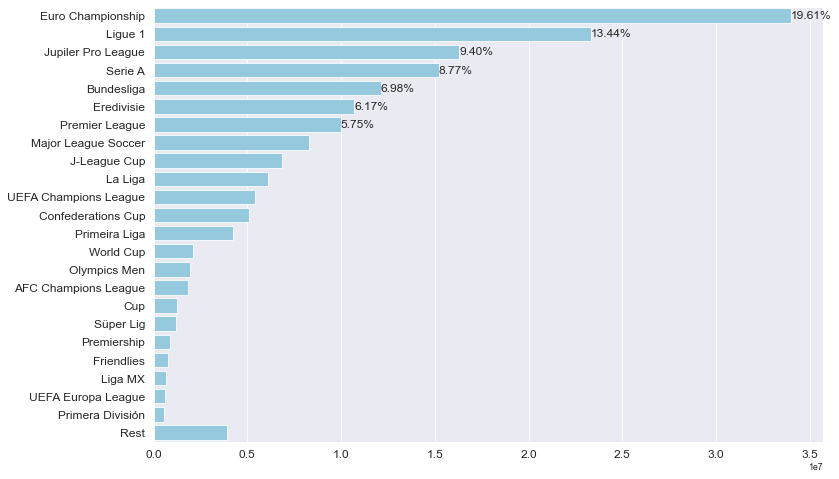

In [309]:
conn = psycopg2.connect("dbname=dbproject user=postgres password=141218")
conn.autocommit = True
cursor = conn.cursor()
sql = '''
SELECT SUM(oh.priceeuro) AS leaguevolume, sea.leaguename
FROM season sea
JOIN playsin pi ON sea.seasonid = pi.seasonid
JOIN player p ON pi.playerid = p.playerid
JOIN card c ON c.firstname = p.firstname AND c.lastname = p.lastname AND c.birthdate = p.birthdate
JOIN nft n ON c.assetid = n.assetid
JOIN ownershiphistory oh ON n.nftid = oh.nftid
GROUP BY sea.leaguename
ORDER BY SUM(oh.priceeuro) DESC
'''

cursor.execute(sql)

# Get all tuples
rows = cursor.fetchall()

# Get the column names
column_names = [column[0] for column in cursor.description]

# Close connection
cursor.close()
conn.close()

# Create & clean df
volume_by_league = pd.DataFrame(rows, columns=column_names)
volume_by_league.loc[23, 'leaguename'] = 'Rest'
volume_by_league.loc[23, 'leaguevolume'] = volume_by_league.loc[volume_by_league['leaguevolume'] < 500000, 'leaguevolume'].sum()
volume_by_league = volume_by_league[volume_by_league['leaguevolume']>= 500000]
volume_by_league['percentage'] = ((volume_by_league['leaguevolume'] / volume_by_league['leaguevolume'].sum()) * 100)
display(volume_by_league)

# Create Plot
plt.figure(figsize=(12, 8))
sns.set_theme(context='paper')
sns.barplot(
    data = volume_by_league,
    x='leaguevolume', y= 'leaguename',
    color = "skyblue")

ax = plt.gca()

for index, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width(), p.get_y() + p.get_height()/2, f'{volume_by_league["percentage"][index]:.2f}%', 
        fontsize=12, ha='left', va='center')
    if index>5:
        break

set_plot_style('')

fig = ax.get_figure()
fig.savefig('g17-trading_volume_by_league.pdf', format='pdf')

### Barplot: Top 20 average card price by league

,leagueaverage,leaguename
0,361.408982,Serie B
1,306.633860,Euro Championship
2,167.569619,UEFA Nations League
3,140.306704,Magyar Kupa
4,137.785994,World Cup - Qualification South America
...,...,...
83,4.184764,Allsvenskan
84,3.733254,First League
85,3.713152,Birinci Dasta
86,3.074450,Paulista - A3


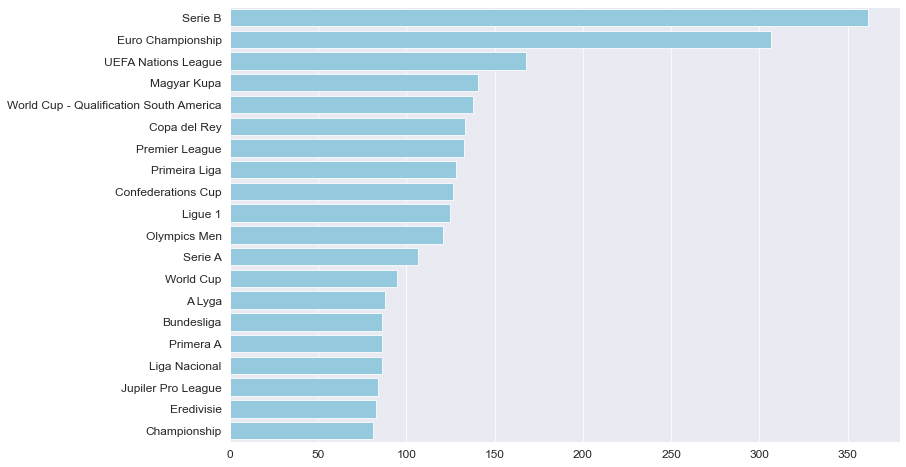

In [313]:
conn = psycopg2.connect("dbname=dbproject user=postgres password=141218")
conn.autocommit = True
cursor = conn.cursor()
sql = '''
SELECT AVG(oh.priceeuro) AS leagueaverage, sea.leaguename
FROM season sea
JOIN playsin pi ON sea.seasonid = pi.seasonid
JOIN player p ON pi.playerid = p.playerid
JOIN card c ON c.firstname = p.firstname AND c.lastname = p.lastname AND c.birthdate = p.birthdate
JOIN nft n ON c.assetid = n.assetid
JOIN ownershiphistory oh ON n.nftid = oh.nftid
GROUP BY sea.leaguename
ORDER BY AVG(oh.priceeuro) DESC
'''

cursor.execute(sql)

# Get all tuples
rows = cursor.fetchall()

# Get the column names
column_names = [column[0] for column in cursor.description]

# Close connection
cursor.close()
conn.close()

# Create df
avg_by_league = pd.DataFrame(rows, columns=column_names)
#avg_by_league.loc[-1, 'leaguename'] = 'Rest'
#avg_by_league = avg_by_league[avg_by_league['leagueaverage']>= 70]
display(avg_by_league)

# Create Plot
plt.figure(figsize=(12, 8))

sns.set_theme(context='paper')
sns.barplot(
    data = avg_by_league[0:20],
    x='leagueaverage', y= 'leaguename',
    color = "skyblue")

ax = plt.gca()

set_plot_style('')

fig = ax.get_figure()
fig.savefig('g17-avg_price_by_league.pdf', format='pdf')

### Check Serie B

In [316]:
conn = psycopg2.connect("dbname=dbproject user=postgres password=141218")
conn.autocommit = True
cursor = conn.cursor()
sql = '''
SELECT oh.priceeuro, sea.leaguename
FROM season sea
JOIN playsin pi ON sea.seasonid = pi.seasonid
JOIN player p ON pi.playerid = p.playerid
JOIN card c ON c.firstname = p.firstname AND c.lastname = p.lastname AND c.birthdate = p.birthdate
JOIN nft n ON c.assetid = n.assetid
JOIN ownershiphistory oh ON n.nftid = oh.nftid
WHERE sea.leaguename = 'Serie B'
ORDER BY oh.priceeuro DESC
'''

cursor.execute(sql)

# Get all tuples
rows = cursor.fetchall()

# Get the column names
column_names = [column[0] for column in cursor.description]

# Close connection
cursor.close()
conn.close()

# Create df
df = pd.DataFrame(rows, columns=column_names)
print(df['priceeuro'].mean())
display(df)

361.4089821456435


,priceeuro,leaguename
0,33667.849584,Serie B
1,21282.960000,Serie B
2,5606.910000,Serie B
3,4615.931919,Serie B
4,4561.536000,Serie B
...,...,...
955,0.363512,Serie B
956,0.362775,Serie B
957,0.360903,Serie B
958,0.300291,Serie B


### Barplot: Trading volume by position

,gamesposition,positionvolume,percentage
0,Attacker,5.126867e+07,29.471050
1,Midfielder,4.524942e+07,26.010973
2,Goalkeeper,4.094295e+07,23.535459
3,Defender,3.650178e+07,20.982518


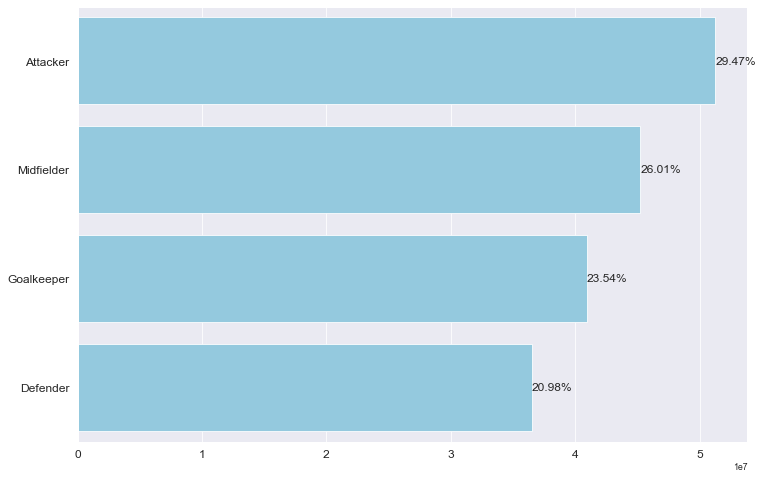

In [338]:
sql = '''
SELECT subquery.gamesposition, SUM(oh.priceeuro) AS positionvolume
FROM (
    SELECT stats.playerid, stats.gamesposition
    FROM statistics stats
    GROUP BY stats.playerid, stats.gamesposition
) AS subquery
JOIN player p ON subquery.playerid = p.playerid
JOIN card c ON c.firstname = p.firstname AND c.lastname = p.lastname AND c.birthdate = p.birthdate
JOIN nft n ON n.assetid = c.assetid
JOIN ownershiphistory oh ON oh.nftid = n.nftid
GROUP BY subquery.gamesposition
ORDER BY SUM(oh.priceeuro) DESC
'''

# Create and clean dataframe
volume_by_pos = execute_query(sql)
volume_by_pos['percentage'] = ((volume_by_pos['positionvolume'] / volume_by_pos['positionvolume'].sum()) * 100)

display(volume_by_pos)

# Create plot
plt.figure(figsize=(12, 8))
sns.set_theme(context='paper')
sns.barplot(
    data = volume_by_pos,
    x='positionvolume', y= 'gamesposition',
    color = "skyblue")

ax = plt.gca()

for index, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width(), p.get_y() + p.get_height()/2, f'{volume_by_pos["percentage"][index]:.2f}%', 
        fontsize=12, ha='left', va='center')

set_plot_style('')

fig = ax.get_figure()
fig.savefig('g17-volume_by_position.pdf', format='pdf')

### Barplot: Average price by position

In [428]:
sql = '''
SELECT subquery.gamesposition, AVG(oh.priceeuro) AS avg_pos_price
FROM (
    SELECT stats.playerid, stats.gamesposition
    FROM statistics stats
    GROUP BY stats.playerid, stats.gamesposition
) AS subquery
JOIN player p ON subquery.playerid = p.playerid
JOIN card c ON c.firstname = p.firstname AND c.lastname = p.lastname AND c.birthdate = p.birthdate
JOIN nft n ON n.assetid = c.assetid
JOIN ownershiphistory oh ON oh.nftid = n.nftid
GROUP BY subquery.gamesposition
ORDER BY AVG(oh.priceeuro) DESC
'''

# Create df
avg_price_by_pos = execute_query(sql)
display(avg_price_by_pos)

# Visualization
plt.figure(figsize=(12, 8))
sns.set_theme(context='paper')
sns.barplot(
    data = avg_price_by_pos,
    x='avg_pos_price', y= 'gamesposition',
    color = "skyblue")

ax = plt.gca()
set_plot_style('')

fig = ax.get_figure()
fig.savefig('g17-avg_price_by_position.pdf', format='pdf')

GroupingError: column "subquery.gamesposition" must appear in the GROUP BY clause or be used in an aggregate function
LINE 2: SELECT subquery.gamesposition, oh.priceeuro
               ^


### Barplot: Number of trades by position

,gamesposition,trades_by_position,percentage
0,Midfielder,619947,33.498100
1,Defender,605182,32.700291
2,Attacker,390607,21.105986
3,Goalkeeper,234957,12.695623


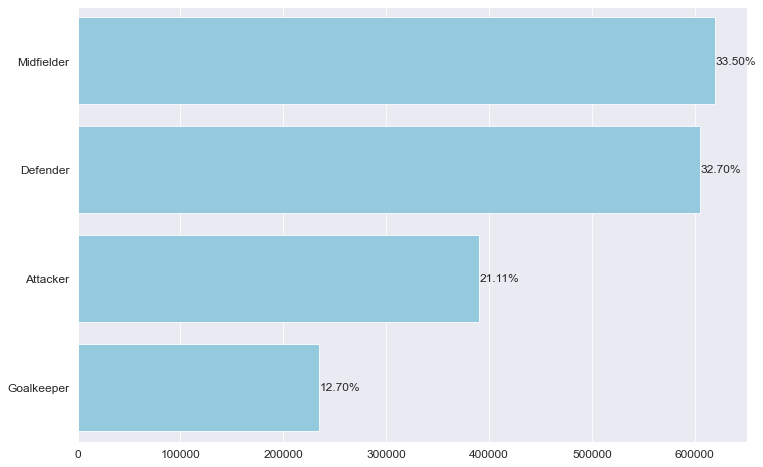

In [400]:
sql = '''
SELECT subquery.gamesposition, COUNT(oh.priceeuro) AS trades_by_position
FROM (
    SELECT stats.playerid, stats.gamesposition
    FROM statistics stats
    GROUP BY stats.playerid, stats.gamesposition
) AS subquery
JOIN player p ON subquery.playerid = p.playerid
JOIN card c ON c.firstname = p.firstname AND c.lastname = p.lastname AND c.birthdate = p.birthdate
JOIN nft n ON n.assetid = c.assetid
JOIN ownershiphistory oh ON oh.nftid = n.nftid
GROUP BY subquery.gamesposition
ORDER BY COUNT(oh.priceeuro) DESC
'''

# Create df
tradecount_by_pos = execute_query(sql)
tradecount_by_pos['percentage'] = ((tradecount_by_pos['trades_by_position'] / tradecount_by_pos['trades_by_position'].sum())*100)
display(tradecount_by_pos)

# Visualization
plt.figure(figsize=(12, 8))
sns.set_theme(context='paper')

sns.barplot(
    data = tradecount_by_pos,
    x='trades_by_position', y= 'gamesposition',
    color = "skyblue")

ax = plt.gca()

for index, p in enumerate(ax.patches):
    if index < 4:
        ax.text(p.get_x() + p.get_width(), p.get_y() + p.get_height()/2, f'{tradecount_by_pos["percentage"][index]:.2f}%', fontsize=12, ha='left', va='center')

set_plot_style('')

fig = ax.get_figure()
fig.savefig('g17-tradecount_by_position.pdf', format='pdf')

,Position,Count,percentage
0,Midfielder,330421,34.448961
1,Defender,322453,33.618235
2,Attacker,194203,20.247174
3,Goalkeeper,112084,11.685629


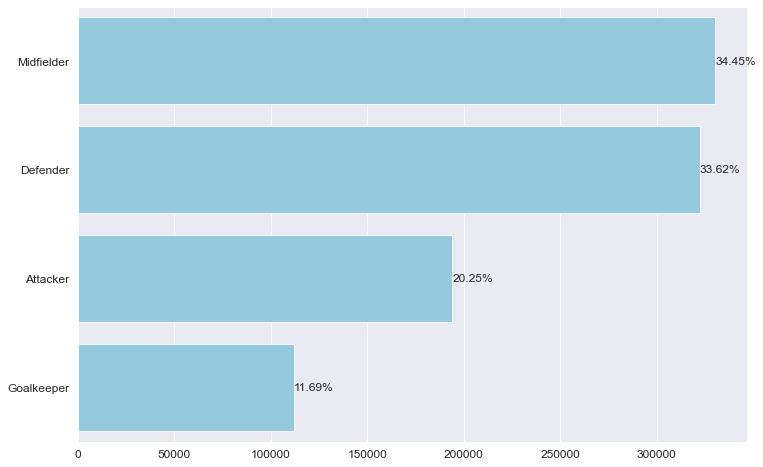

In [402]:
sql = '''
SELECT p.playerid, c.assetid
FROM card c
JOIN player p ON c.firstname = p.firstname AND c.lastname = p.lastname AND c.birthdate = p.birthdate
'''

# Create df
player_asset = execute_query(sql)
#display(player_asset)

sql = '''
SELECT DISTINCT stats.playerid, stats.gamesposition
FROM statistics stats
'''

# Create df
player_games = execute_query(sql)
#display(player_games)

# Merge with pandas
group_sizes = pd.merge(player_asset, player_games, on="playerid").groupby('gamesposition').size()
cards_by_position = pd.DataFrame()
cards_by_position['Position'] = ['Midfielder', 'Defender', 'Attacker', 'Goalkeeper']
cards_by_position['Count'] = [330421, 322453, 194203, 112084]
cards_by_position['percentage'] = ((cards_by_position['Count'] / cards_by_position['Count'].sum())*100)
display(cards_by_position)

# Visualization
plt.figure(figsize=(12, 8))
sns.set_theme(context='paper')

sns.barplot(
    data = cards_by_position,
    x='Count', y= 'Position',
    color = "skyblue")

ax = plt.gca()

for index, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width(), p.get_y() + p.get_height()/2, f'{cards_by_position["percentage"][index]:.2f}%', fontsize=12, ha='left', va='center')

set_plot_style('')

fig = ax.get_figure()
fig.savefig('g17-cards_by_position.pdf', format='pdf')

### Do goalkeepers/strikers/... have a significantly higher avg_price compared to other positions?}

In [419]:
# Average price for goalkeepers and non-goalkeepers
mean_gk_price = log(174.257197)
mean

n_gk = 112084
n_nongk = 330421+194203+322453

# Perform the z-test
z_stat, p_value = proportions_ztest(count=n_gk, nobs=n_gk+n_nongk, value=mean_gk_price)

# Print the z-statistic and p-value
print(f'z-statistic: {z_stat:.3f}, p-value: {p_value:.3f}')



z-statistic: -530888.603, p-value: 0.000


## Explorative Analysis

In [216]:
sql = '''
SELECT c.playerid, a.priceeuro as price, b.leaguename as league,b.seasonid, c.goalstotal as goals, c.goalsassists as assists,
    c.gamesposition as position, c.gamesminutes as minutes_played, d.rarity
FROM card d
JOIN nft e ON d.assetid = e.assetid
JOIN ownershiphistory a ON e.nftid = a.nftid
JOIN player f ON d.firstname = f.firstname AND d.lastname = f.lastname AND d.birthdate = f.birthdate
JOIN playsin g ON f.playerid = g.playerid
JOIN season b ON g.seasonid = b.seasonid
JOIN statistics c ON b.seasonid = c.seasonid AND g.playerid = c.playerid
'''
df = execute_query(sql)
display(df)

,playerid,price,league,seasonid,goals,assists,position,minutes_played,rarity
0,2737,17.829048,UEFA Nations League,1746,1.0,NaN,Attacker,348.0,limited
1,2737,17.829048,Friendlies,1698,1.0,NaN,Attacker,126.0,limited
2,2737,17.829048,Coupe de France,383,0.0,NaN,Attacker,90.0,limited
3,2737,17.829048,Coupe de France,385,0.0,NaN,Attacker,120.0,limited
4,2737,17.829048,League Cup,942,0.0,NaN,Attacker,137.0,limited
...,...,...,...,...,...,...,...,...,...
33330751,129040,1.642170,Eredivisie,95,NaN,NaN,Midfielder,NaN,limited
33330752,129040,1.642170,Eredivisie,93,0.0,NaN,Midfielder,0.0,limited
33330753,129040,1.642170,Eredivisie,94,0.0,NaN,Midfielder,3.0,limited
33330754,129040,1.642170,Eredivisie,92,0.0,NaN,Midfielder,45.0,limited


### Same query with log(price)

In [330]:
sql = '''
SELECT stats.playerid, LOG(oh.priceeuro) AS log_price, sea.leaguename AS league, sea.seasonid, stats.goalstotal as goals, stats.goalsassists AS assists,
    stats.gamesposition AS position, stats.gamesminutes as minutes_played, c.rarity
FROM card c
JOIN nft n ON c.assetid = n.assetid
JOIN ownershiphistory oh ON n.nftid = oh.nftid
JOIN player p ON c.firstname = p.firstname AND c.lastname = p.lastname AND c.birthdate = p.birthdate
JOIN playsin pi ON p.playerid = pi.playerid
JOIN season sea ON pi.seasonid = sea.seasonid
JOIN statistics stats ON sea.seasonid = stats.seasonid AND pi.playerid = stats.playerid
'''

df = execute_query(sql)

# Clean dataset

## df["assists"].isna().sum()/df.shape[0] #82% missing values, drop assists
df.drop(["assists"],axis=1 ,inplace=True)

# Create Top-5-League and Nationalteam variable
df["topleague"] = np.where(df["league"].isin(["Bundesliga","Primera Division","Premier League", "Ligue 1","Serie A"]),1,0)
nationalcups = [range(1293,1297),2233,range(1297,1301),range(1746,1749),range(148,151),
                range(1823,1830),561]
df["nationalteam"] = np.where(df["seasonid"].isin(nationalcups),1,0)

display(df)

,playerid,log_price,league,seasonid,goals,position,minutes_played,rarity,topleague,nationalteam
0,51158,0.334214,Friendlies,1698,0.0,Midfielder,27.0,limited,0,0
1,153372,1.546881,Jupiler Pro League,30,0.0,Midfielder,343.0,limited,0,0
2,153372,1.546881,Cup,2021,0.0,Midfielder,22.0,limited,0,0
3,153372,1.587848,Jupiler Pro League,30,0.0,Midfielder,343.0,limited,0,0
4,153372,1.587848,Cup,2021,0.0,Midfielder,22.0,limited,0,0
...,...,...,...,...,...,...,...,...,...,...
33330751,1752,1.007062,League Cup,1735,1.0,Midfielder,286.0,limited,0,0
33330752,1752,1.007062,FA Cup,913,1.0,Midfielder,119.0,limited,0,0
33330753,1752,1.007062,UEFA Europa League,1270,0.0,Midfielder,209.0,limited,0,0
33330754,1752,1.007062,Championship,895,0.0,Midfielder,16.0,limited,0,0


In [182]:
reg_data = df.drop(['seasonid','playerid','minutes_played'],axis=1)

# Fairly high correlation between minutes played and goals
# Also slight correlation between minutes_played and topleague. -> Drop minutes_played for regression

# Remove nan rows
reg_data = df.dropna()

# Only using topleague to further reduce the size
only_top5 = df.loc[df["topleague"] == 1] 

### Average League price

In [325]:
sql = '''
SELECT LOG(AVG(oh.priceeuro)) AS avg_league_price, sea.leaguename AS league
FROM card c
JOIN nft n ON c.assetid = n.assetid
JOIN ownershiphistory oh ON n.nftid = oh.nftid
JOIN player p ON c.firstname = p.firstname AND c.lastname = p.lastname AND c.birthdate = p.birthdate
JOIN playsin pi ON p.playerid = pi.playerid
JOIN season sea ON pi.seasonid = sea.seasonid
GROUP BY sea.leaguename
'''

df = execute_query(sql)
display(df)

,avg_league_price,league
0,1.319273,1. Deild
1,1.931818,1. Division
2,1.619614,1. Lig
3,1.833932,1. SNL
4,1.421927,1st Division
...,...,...
164,2.259983,World Cup - Qualification Europe
165,1.551497,World Cup - Qualification Oceania
166,2.250073,World Cup - Qualification South America
167,1.353774,Ykkönen


### Regression 1: log_price on rarity

In [186]:
y, X = dmatrices('log_price ~ rarity', data=reg_data, return_type='dataframe')

model = sm.OLS(y,X)
results = model.fit()

results.summary()
#sm.stats.linear_rainbow(results)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                 3.446e+06
Date:                Sun, 08 Jan 2023   Prob (F-statistic):               0.00
Time:                        12:38:42   Log-Likelihood:            -3.5231e+07
No. Observations:            33273613   AIC:                         7.046e+07
Df Residuals:                33273609   BIC:                         7.046e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.1130      0.000   7995.875      0.000       1.113       1.113
rarity[T.rare]           0.8466      0.000   2937.203      0.000       0.846       0.847
rarity[T.super_rare]     1.3771      0.001   1360.027      0.000       1.375       1.379
rarity[T.unique]         2.3424      0.004    649.098      0.000       2.335       2.350
==============================================================================
Omnibus:                   430142.504   Durbin-Watson:                   0.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           278135.698
Skew:                           0.082   Prob(JB):                         0.00
Kurtosis:                       2.583   Cond. No.                         30.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Regression 2: log_price on position

In [187]:
y, X = dmatrices('log_price ~ position', data=reg_data, return_type='dataframe')

model = sm.OLS(y,X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                 8.203e+05
Date:                Sun, 08 Jan 2023   Prob (F-statistic):               0.00
Time:                        12:41:15   Log-Likelihood:            -3.8545e+07
No. Observations:            33273613   AIC:                         7.709e+07
Df Residuals:                33273609   BIC:                         7.709e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.4983      0.000   5229.897      0.000       1.498       1.499
position[T.Defender]      -0.3440      0.000   -927.386      0.000      -0.345      -0.343
position[T.Goalkeeper]     0.2727      0.000    574.402      0.000       0.272       0.274
position[T.Midfielder]    -0.2721      0.000   -740.263      0.000      -0.273      -0.271
==============================================================================
Omnibus:                   384489.641   Durbin-Watson:                   0.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           312526.249
Skew:                           0.167   Prob(JB):                         0.00
Kurtosis:                       2.662   Cond. No.                         5.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Regression 3: log_price on position and rarity

In [189]:
y, X = dmatrices('log_price ~ rarity + position', data=reg_data, return_type='dataframe')

model = sm.OLS(y,X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                 2.445e+06
Date:                Sun, 08 Jan 2023   Prob (F-statistic):               0.00
Time:                        12:44:43   Log-Likelihood:            -3.3655e+07
No. Observations:            33273613   AIC:                         6.731e+07
Df Residuals:                33273606   BIC:                         6.731e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.2678      0.000   4934.428      0.000       1.267       1.268
rarity[T.rare]             0.8477      0.000   3082.866      0.000       0.847       0.848
rarity[T.super_rare]       1.3751      0.001   1423.882      0.000       1.373       1.377
rarity[T.unique]           2.3157      0.003    672.794      0.000       2.309       2.322
position[T.Defender]      -0.3292      0.000  -1027.806      0.000      -0.330      -0.329
position[T.Goalkeeper]     0.2980      0.000    726.757      0.000       0.297       0.299
position[T.Midfielder]    -0.2563      0.000   -807.650      0.000      -0.257      -0.256
==============================================================================
Omnibus:                   214509.535   Durbin-Watson:                   0.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           150752.068
Skew:                           0.032   Prob(JB):                         0.00
Kurtosis:                       2.677   Cond. No.                         34.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Regression 4: log_price on rarity + position + goals

In [ ]:
y, X = dmatrices('log_price ~ goals  + rarity + position', data=reg_data, return_type='dataframe')

model = sm.OLS(y,X)
results = model.fit()

results.summary()

### Regression 5: log_price on rarity + position + goals + league (only top 5 leagues considered)

In [168]:
y, X = dmatrices('log_price ~ goals  + rarity + position + league', data=only_top5, return_type='dataframe')

model = sm.OLS(y,X)
results = model.fit()

NameError: name 'only_top5' is not defined

In [228]:
results.summary()
#results.params
#sm.stats.linear_rainbow(results)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                 1.949e+05
Date:                Sat, 07 Jan 2023   Prob (F-statistic):               0.00
Time:                        01:50:52   Log-Likelihood:            -4.3683e+06
No. Observations:             4485134   AIC:                         8.737e+06
Df Residuals:                 4485122   BIC:                         8.737e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.1598      0.001   1282.424      0.000       1.158       1.162
rarity[T.rare]                 0.8005      0.001   1101.986      0.000       0.799       0.802
rarity[T.super_rare]           1.3191      0.003    525.655      0.000       1.314       1.324
rarity[T.unique]               2.2349      0.008    265.947      0.000       2.218       2.251
position[T.Defender]          -0.2118      0.001   -228.819      0.000      -0.214      -0.210
position[T.Goalkeeper]         0.3967      0.001    335.002      0.000       0.394       0.399
position[T.Midfielder]        -0.1654      0.001   -189.719      0.000      -0.167      -0.164
league[T.Ligue 1]              0.1372      0.001    159.186      0.000       0.135       0.139
league[T.Premier League]       0.0077      0.001      9.005      0.000       0.006       0.009
league[T.Primera Division]    -0.6567      0.015    -42.426      0.000      -0.687      -0.626
league[T.Serie A]              0.0786      0.001     99.402      0.000       0.077       0.080
goals                          0.0359   9.57e-05    375.415      0.000       0.036       0.036
==============================================================================
Omnibus:                    11555.800   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9766.114
Skew:                          -0.055   Prob(JB):                         0.00
Kurtosis:                       2.800   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [229]:
y, X = dmatrices('log_price ~ goals', data=only_top5, return_type='dataframe')

model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                 1.440e+05
Date:                Sat, 07 Jan 2023   Prob (F-statistic):               0.00
Time:                        01:54:16   Log-Likelihood:            -5.1735e+06
No. Observations:             4485134   AIC:                         1.035e+07
Df Residuals:                 4485132   BIC:                         1.035e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3315      0.000   3238.498      0.000       1.331       1.332
goals          0.0386      0.000    379.512      0.000       0.038       0.039
==============================================================================
Omnibus:                    33594.328   Durbin-Watson:                   0.213
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28721.107
Skew:                           0.140   Prob(JB):                         0.00
Kurtosis:                       2.725   Cond. No.                         4.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [230]:
y, X = dmatrices('log_price ~ goals + position', data=only_top5, return_type='dataframe')

model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                 1.098e+05
Date:                Sat, 07 Jan 2023   Prob (F-statistic):               0.00
Time:                        01:58:14   Log-Likelihood:            -5.0348e+06
No. Observations:             4485134   AIC:                         1.007e+07
Df Residuals:                 4485129   BIC:                         1.007e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.4149      0.001   1542.476      0.000       1.413       1.417
position[T.Defender]      -0.2126      0.001   -198.069      0.000      -0.215      -0.211
position[T.Goalkeeper]     0.3807      0.001    277.249      0.000       0.378       0.383
position[T.Midfielder]    -0.1767      0.001   -174.794      0.000      -0.179      -0.175
goals                      0.0388      0.000    349.352      0.000       0.039       0.039
==============================================================================
Omnibus:                    28790.506   Durbin-Watson:                   0.218
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26008.244
Skew:                           0.145   Prob(JB):                         0.00
Kurtosis:                       2.766   Cond. No.                         22.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [232]:
y, X = dmatrices('log_price ~ league', data=only_top5, return_type='dataframe')

model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                 1.280e+04
Date:                Sat, 07 Jan 2023   Prob (F-statistic):               0.00
Time:                        02:02:04   Log-Likelihood:            -5.2189e+06
No. Observations:             4485134   AIC:                         1.044e+07
Df Residuals:                 4485129   BIC:                         1.044e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.3039      0.001   2107.067      0.000       1.303       1.305
league[T.Ligue 1]              0.2162      0.001    208.331      0.000       0.214       0.218
league[T.Premier League]       0.1097      0.001    107.127      0.000       0.108       0.112
league[T.Primera Division]    -0.4949      0.019    -26.465      0.000      -0.532      -0.458
league[T.Serie A]              0.1484      0.001    156.029      0.000       0.147       0.150
==============================================================================
Omnibus:                    34282.189   Durbin-Watson:                   0.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30692.108
Skew:                           0.158   Prob(JB):                         0.00
Kurtosis:                       2.747   Cond. No.                         54.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Do national team players get traded more often than the rest?

In [180]:
# National players are traded more often?

df2 = df.loc[df["nationalteam"]==1]
df2 = df2.drop_duplicates(subset=["playerid"])


In [181]:
df2.count() #209 national players
209/10511 #2% national players

0.019883931119779277

In [182]:
st.ttest_1samp(df["playerid"].isin(df2["playerid"]),0.02,alternative='greater') # national team players get traded more: pvalue = 0

Ttest_1sampResult(statistic=480.5071313134655, pvalue=0.0)

### Check the correlation between the regressors

<AxesSubplot:>

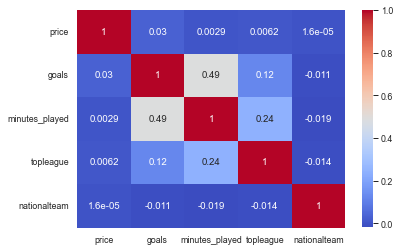

In [191]:
regressors = df.drop(["seasonid","playerid"],axis=1)

# Compute correlation matrix and visualize in heatmap
corr = regressors.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")

# Fairly high correlation between minutes played and goals
# Also slight correlation between minutes_played and topleague. -> Drop minutes_played for regression

In [192]:
df4 = df3.drop(["minutes_played"],axis=1)
df4.head()
#remove nan rows
df4 = df4.dropna()
df4.head()
df4 = df4.loc[df4["topleague"] == 1] # only using topleague to further reduce the size

In [185]:
'''
X = df4.iloc[:,1:]

y = df4.iloc[:,0]
'''

'\nX = df4.iloc[:,1:]\n\ny = df4.iloc[:,0]\n'

In [186]:
'''reg = lm.LinearRegression().fit(X,y)'''

'reg = lm.LinearRegression().fit(X,y)'

In [187]:
'''reg.score(X,y) #R2 score of 0.1
reg.coef_'''

'reg.score(X,y) #R2 score of 0.1\nreg.coef_'

In [ ]:
from patsy import dmatrices

y, X = dmatrices('price ~ goals  + rarity + position + league', data=df4, return_type='dataframe')

model = sm.OLS(y,X)
results = model.fit()
results.summary()

In [ ]:
results.params
sm.stats.linear_rainbow(results)

### (Scatterplot between playerheight and average price)

We wanted to see if there is a correlation between the height of a player and its average card price.

,firstname,lastname,heightcm,weightkg,avg_price
0,Aamet José,Calderón Tello,184,81,15.913990
1,Aaron,Bastiaans,184,68,65.698594
2,Aaron,Herrera,180,71,46.671281
3,Aaron,McEneff,175,70,7.944332
4,Aaron,Meijers,176,77,3.297479
...,...,...,...,...,...
10504,Şener,Özbayraklı,171,71,11.689705
10505,Ştefan Daniel,Radu,183,79,49.063816
10507,Šime,Vrsaljko,181,76,28.054219
10508,Žan,Kolmanič,177,69,69.909020


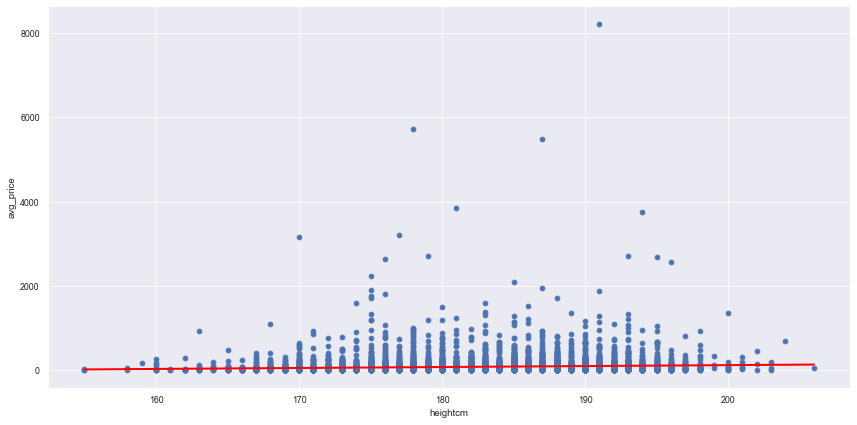

In [84]:
# Next up: Make a scatterplot between a player height and card prices

sql = '''
SELECT p.firstname, p.lastname, p.heightcm, p.weightkg , AVG(oh.priceeuro) AS avg_price
FROM player p
JOIN card c ON c.firstname = p.firstname AND c.lastname = p.lastname AND c.birthdate = p.birthdate
JOIN nft n ON c.assetid = n.assetid
JOIN ownershiphistory oh ON n.nftid = oh.nftid
GROUP BY p.firstname, p.lastname, p.birthdate
'''

# Create df
df = execute_query(sql)

# Quick manual check
#print(df[df['lastname'] == 'Akanji'])
#print(df[df['avg_price'] > 2000])

# Drop rows where we do not have the height or weigth of the player
df.drop(df[df['heightcm'] == 0].index, inplace=True)
df.drop(df[df['weightkg'] == 0].index, inplace=True)
display(df)


# Visualize
sns.set_theme(context='paper')
sns.relplot(
    data = df, kind='scatter',
    x='heightcm', y= 'avg_price', height=6, aspect=2)

sns.regplot(x='heightcm', y='avg_price', data=df, line_kws={'color': 'red', 'lw': 2})
plt.show()

In [ ]:
sql = '''
SELECT subquery.gamesposition, oh.priceeuro AS price
FROM (
    SELECT stats.playerid, stats.gamesposition
    FROM statistics stats
    GROUP BY stats.playerid
) AS subquery
JOIN player p ON subquery.playerid = p.playerid
JOIN card c ON c.firstname = p.firstname AND c.lastname = p.lastname AND c.birthdate = p.birthdate
JOIN nft n ON n.assetid = c.assetid
JOIN ownershiphistory oh ON oh.nftid = n.nftid
ORDER BY oh.priceeuro DESC
'''

# Create df
avg_price_by_pos = execute_query(sql)